# Activation Visualization

This notebook demonstrates how to visualize model activations by class and dataset using dimensionality reduction.

## Overview

Visualization techniques:
- **t-SNE**: Non-linear dimensionality reduction for 2D visualization
- **PCA**: Linear projection to principal components
- **UMAP**: Uniform Manifold Approximation (optional)

We'll visualize:
- Class separation (malicious vs benign)
- Dataset clustering (which datasets cluster together)

In [10]:
from prompt_mining.classifiers import ClassificationDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 1. Load Activations

In [ ]:
# Load dataset
# Update this path to point to your ingestion output
dataset = ClassificationDataset.from_path("/path/to/activations")
data = dataset.load(layer=31, space='raw', position=[-5])
print(dataset.summary(data))

X, y, datasets = data.X, data.y, data.datasets

## 2. Subsample for Visualization

t-SNE is slow on large datasets, so we subsample.

In [3]:
# Subsample for visualization
n_vis = 10000
np.random.seed(42)
vis_idx = np.random.choice(len(X), n_vis, replace=False)

X_vis = X[vis_idx]
y_vis = y[vis_idx]
datasets_vis = datasets[vis_idx]

print(f"Visualization sample: {n_vis} points")
print(f"Class balance: {y_vis.mean():.1%} malicious")

Visualization sample: 10000 points
Class balance: 46.3% malicious


## 3. t-SNE Visualization

In [17]:
# Normalize
scaler = StandardScaler()
X_vis_norm = scaler.fit_transform(X_vis)

# Run t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_vis_norm)
print("Done")

Running t-SNE...
Done


### 3.1 Color by Class

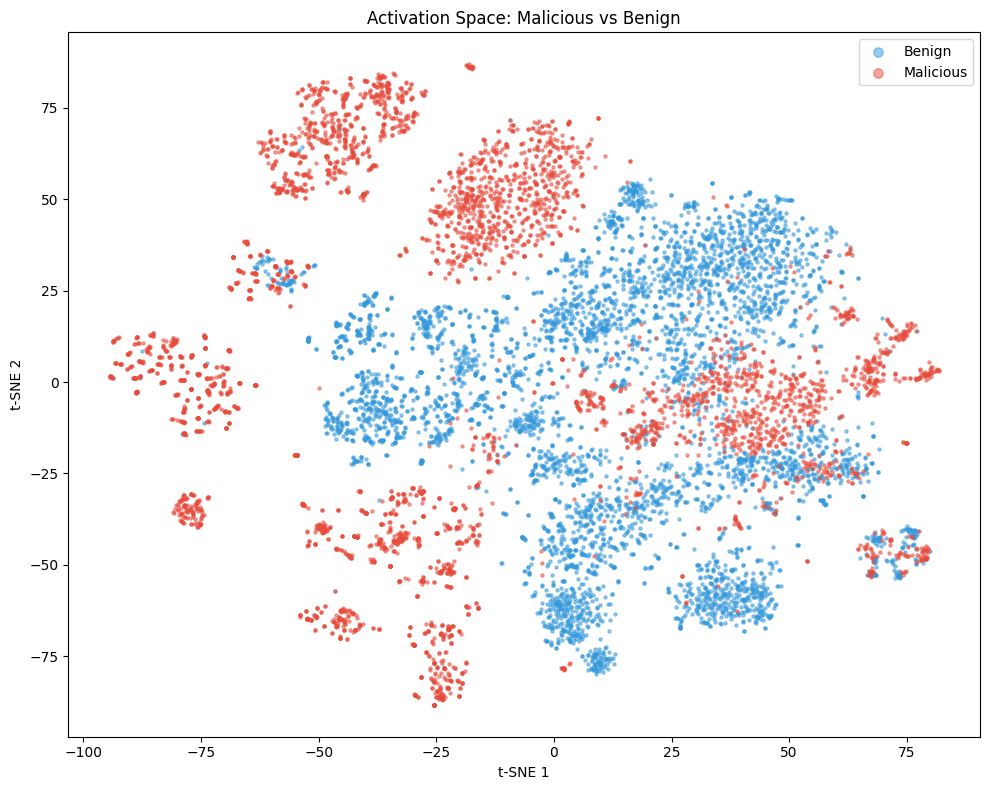

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot benign first (background), then malicious (foreground)
benign_mask = y_vis == 0
ax.scatter(X_tsne[benign_mask, 0], X_tsne[benign_mask, 1], 
           c='#3498db', s=5, alpha=0.5, label='Benign')
ax.scatter(X_tsne[~benign_mask, 0], X_tsne[~benign_mask, 1], 
           c='#e74c3c', s=5, alpha=0.5, label='Malicious')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Activation Space: Malicious vs Benign')
ax.legend(markerscale=3)
plt.tight_layout()
plt.show()

### 3.2 Color by Dataset

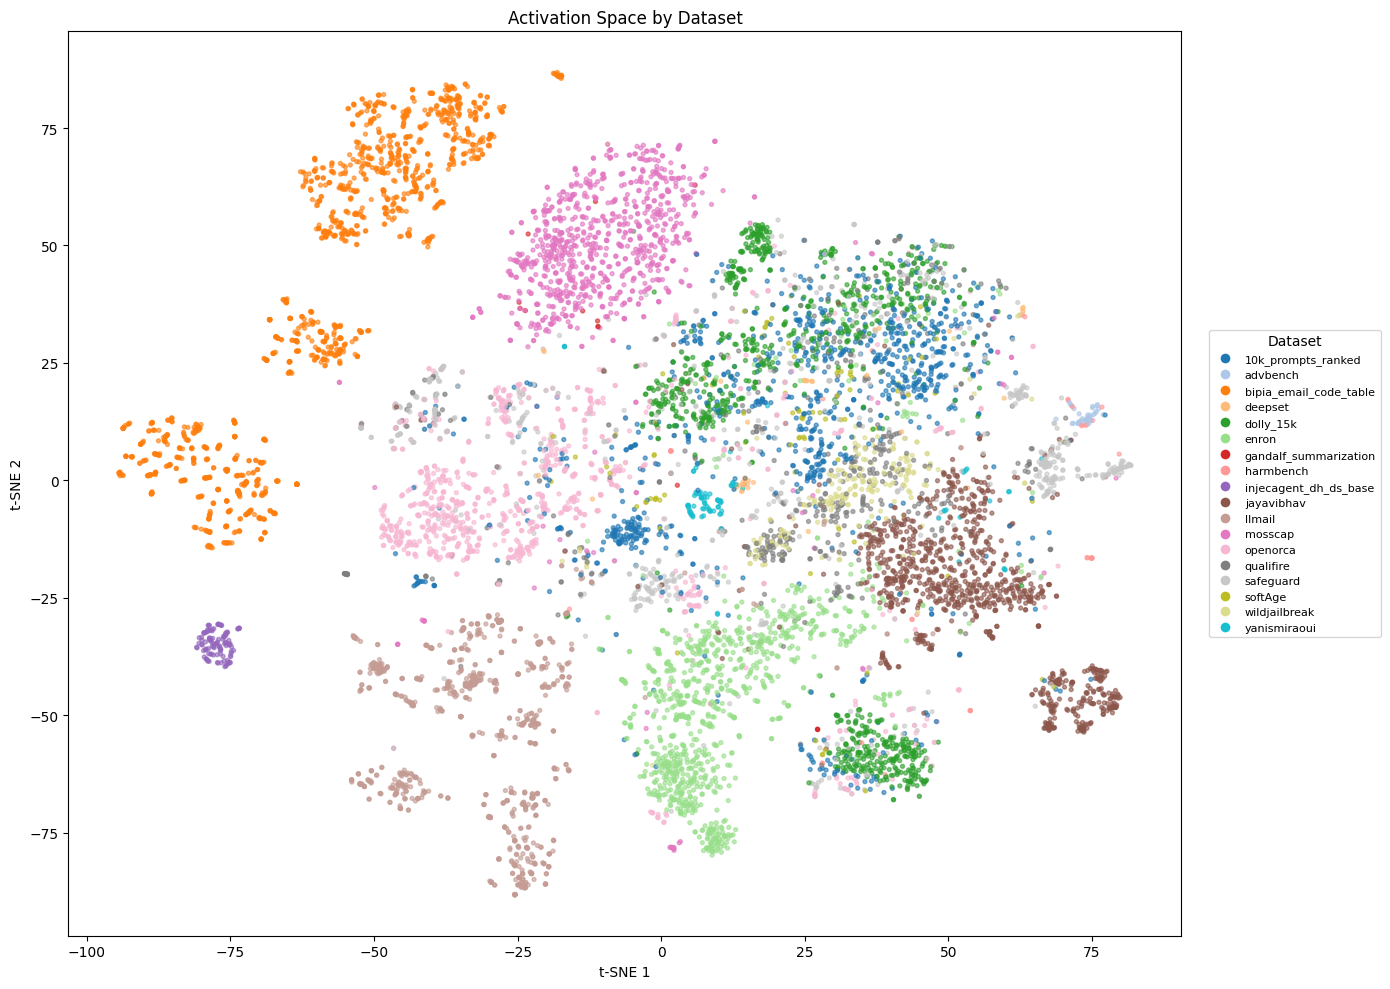

In [ ]:
# Map datasets to colors
unique_ds = np.unique(datasets_vis)
ds_colors = {ds: plt.cm.tab20(i / len(unique_ds)) for i, ds in enumerate(unique_ds)}
ds_color_arr = [ds_colors[ds] for ds in datasets_vis]

fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=ds_color_arr, s=8, alpha=0.6)

# Legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=ds_colors[ds], markersize=8, label=ds) 
                  for ds in unique_ds]
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.02, 0.5), 
          fontsize=14, title='Dataset')

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Activation Space by Dataset')
plt.tight_layout()
plt.show()

## 4. PCA Visualization

PCA is faster and shows linear structure.

In [7]:
# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis_norm)

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.1%}")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.1%}")

Explained variance: 21.8%
  PC1: 15.5%
  PC2: 6.3%


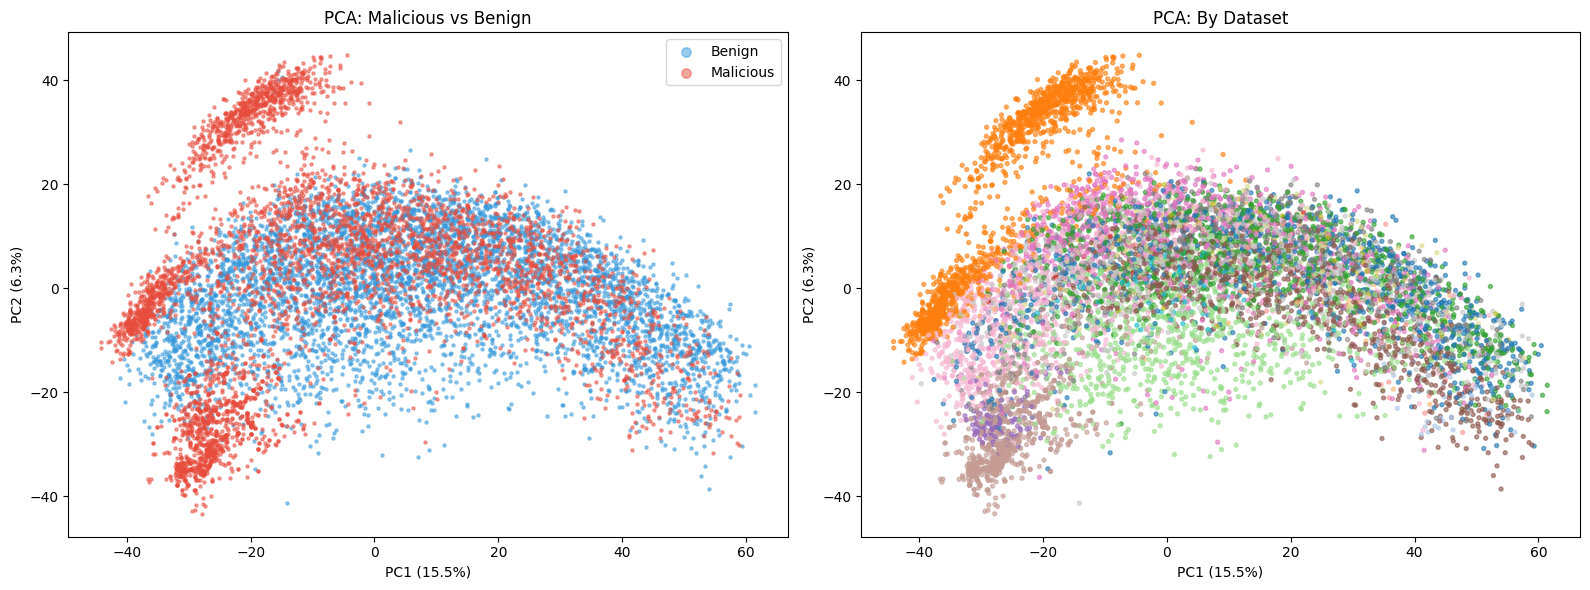

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By class
ax = axes[0]
ax.scatter(X_pca[benign_mask, 0], X_pca[benign_mask, 1], 
           c='#3498db', s=5, alpha=0.5, label='Benign')
ax.scatter(X_pca[~benign_mask, 0], X_pca[~benign_mask, 1], 
           c='#e74c3c', s=5, alpha=0.5, label='Malicious')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA: Malicious vs Benign')
ax.legend(markerscale=3)

# By dataset
ax = axes[1]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=ds_color_arr, s=8, alpha=0.6)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA: By Dataset')

plt.tight_layout()
plt.show()

## 5. Per-Dataset Distribution Analysis

In [11]:
# Compute per-dataset statistics in PCA space
stats = []
for ds in unique_ds:
    mask = datasets_vis == ds
    X_ds = X_pca[mask]
    y_ds = y_vis[mask]
    
    stats.append({
        'Dataset': ds,
        'N': mask.sum(),
        'Pos%': y_ds.mean() * 100,
        'PC1_mean': X_ds[:, 0].mean(),
        'PC1_std': X_ds[:, 0].std(),
        'PC2_mean': X_ds[:, 1].mean(),
        'PC2_std': X_ds[:, 1].std(),
    })

stats_df = pd.DataFrame(stats).sort_values('PC1_mean')
print("Per-Dataset Statistics in PCA Space")
print("=" * 70)

display(stats_df.style.format({
    'Pos%': '{:.0f}%',
    'PC1_mean': '{:.2f}',
    'PC1_std': '{:.2f}',
    'PC2_mean': '{:.2f}',
    'PC2_std': '{:.2f}',
}))

Per-Dataset Statistics in PCA Space


,Dataset,N,Pos%,PC1_mean,PC1_std,PC2_mean,PC2_std
8,injecagent_dh_ds_base,112,100%,-26.98,3.57,-25.18,3.49
2,bipia_email_code_table,1436,95%,-25.54,9.93,17.52,17.87
10,llmail,915,100%,-23.21,9.79,-25.90,9.25
12,openorca,973,0%,-14.19,19.78,-2.67,11.25
6,gandalf_summarization,14,100%,-7.89,13.67,5.76,5.28
17,yanismiraoui,90,100%,1.65,10.80,0.92,5.40
11,mosscap,944,100%,2.51,19.19,7.53,10.09
5,enron,963,0%,4.74,16.73,-8.35,8.90
16,wildjailbreak,213,92%,8.58,19.85,5.22,8.37
14,safeguard,795,30%,9.30,23.62,2.14,8.90


## 6. Dataset Centroid Visualization

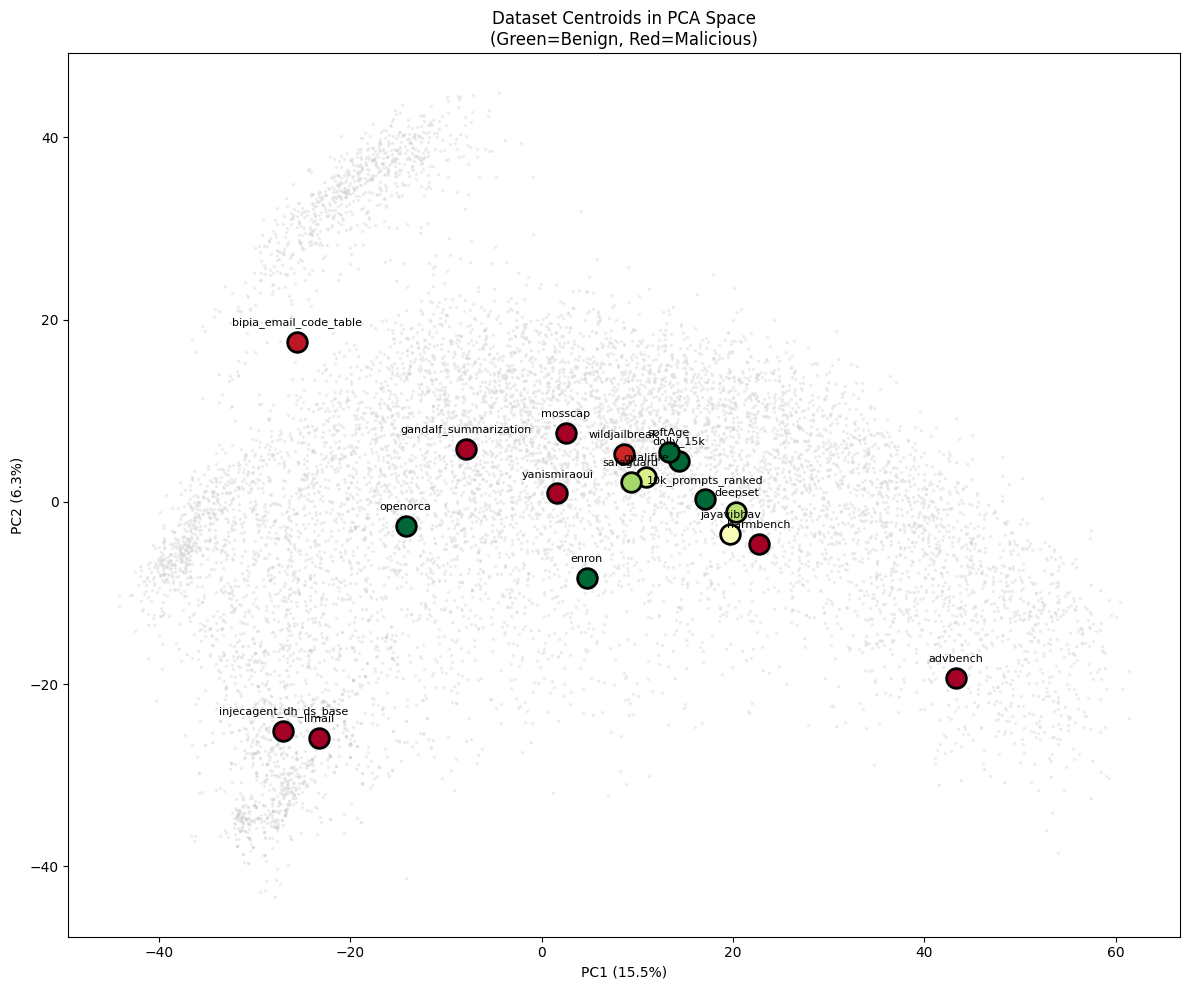

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all points faintly
ax.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=2, alpha=0.3)

# Plot centroids
for ds in unique_ds:
    mask = datasets_vis == ds
    centroid = X_pca[mask].mean(axis=0)
    pos_rate = y_vis[mask].mean()
    
    # Color by class balance
    color = plt.cm.RdYlGn(1 - pos_rate)  # Green=benign, Red=malicious
    ax.scatter(centroid[0], centroid[1], c=[color], s=200, edgecolors='black', linewidth=2)
    ax.annotate(ds, centroid, fontsize=8, ha='center', va='bottom', 
                xytext=(0, 10), textcoords='offset points')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Dataset Centroids in PCA Space\n(Green=Benign, Red=Malicious)')
plt.tight_layout()
plt.show()

## 7. Class Separation by Dataset

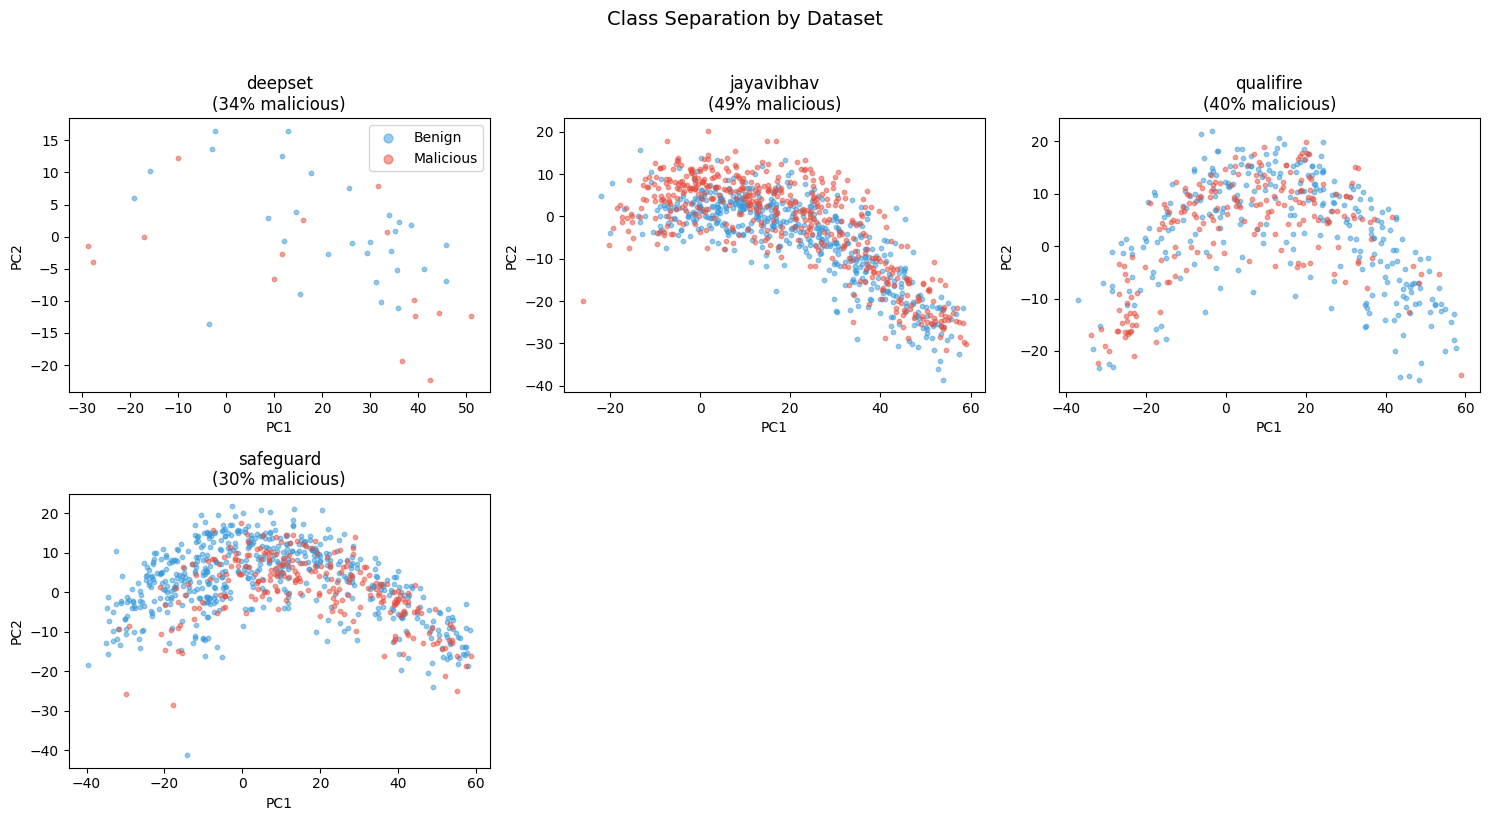

In [13]:
# Select datasets with both classes for this visualization
mixed_datasets = [ds for ds in unique_ds 
                  if 0.1 < y_vis[datasets_vis == ds].mean() < 0.9]

n_cols = 3
n_rows = (len(mixed_datasets) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, ds in enumerate(mixed_datasets):
    ax = axes[i]
    mask = datasets_vis == ds
    X_ds = X_pca[mask]
    y_ds = y_vis[mask]
    
    ax.scatter(X_ds[y_ds == 0, 0], X_ds[y_ds == 0, 1], 
               c='#3498db', s=10, alpha=0.5, label='Benign')
    ax.scatter(X_ds[y_ds == 1, 0], X_ds[y_ds == 1, 1], 
               c='#e74c3c', s=10, alpha=0.5, label='Malicious')
    ax.set_title(f'{ds}\n({y_ds.mean()*100:.0f}% malicious)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    if i == 0:
        ax.legend(markerscale=2)

# Hide empty subplots
for j in range(len(mixed_datasets), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Class Separation by Dataset', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **t-SNE visualization** for non-linear structure
2. **PCA visualization** for linear structure
3. **Class separation** analysis (malicious vs benign)
4. **Dataset clustering** patterns
5. **Per-dataset class separation** for mixed datasets

### Typical Insights

- Some datasets cluster tightly together (similar prompts)
- Others spread across multiple regions (diverse prompts)
- Class separation varies by dataset type
- Indirect injection attacks often overlap with benign instructions